<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Carolina Barba Anaya y Jose Antonio Contreras Peña.

**Fecha:** 23 de Noviembre del 2021.

**Expediente** : if720071 y if721860
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Carolina1002/ProyectoConjunto_CBarba_JAContreras.git

# Tarea 8: 

Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y además deben de comparar con los resultados teoricos del método de valuación de Black-Scholes (ecuación del principio de clase)

### CODIGO CAROLINA

In [1]:
#Librerias
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import yfinance as yf
from datetime import date
import seaborn as sns; sns.set();
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def get_adj_closes(tickers, start_date=None, end_date=None):
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    closes = closes['Adj Close']
    closes.sort_index(inplace=True)
    return closes

def daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

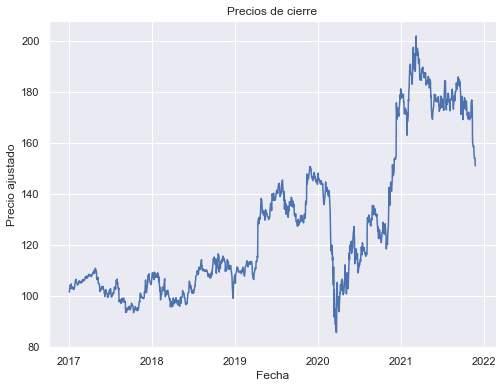

In [3]:
#Precios de cierre DISNEY
ticker = ["DIS"]
start_date = "2017-01-01"
closes_dis = get_adj_closes(ticker, start_date)
plt.figure(figsize = [8, 6])
plt.plot(closes_dis)
plt.title("Precios de cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio ajustado")
plt.show()


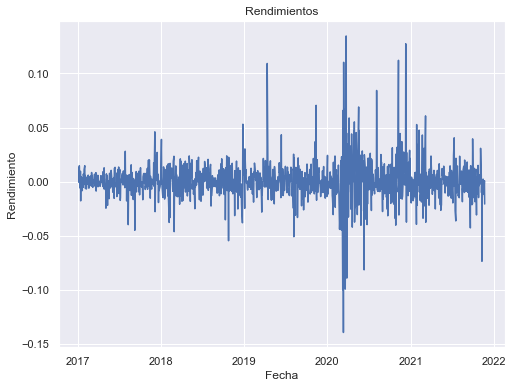

In [4]:
# Rendimientos
rend = daily_ret(closes_dis)
plt.figure(figsize = [8, 6])
plt.plot(rend)
plt.title("Rendimientos")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento")
plt.show()

In [5]:
import requests

def obtener_datos_opciones(symbol):
    headers = headers = {
            'Connection': 'keep-alive',
            'Expires': str(-1),
            'Upgrade-Insecure-Requests': str(1),
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
    }
    url = f'https://query1.finance.yahoo.com/v7/finance/options/{symbol}'
    r = requests.get(url, headers=headers)
    dates = r.json()['optionChain']['result'][0]['expirationDates']
    
    calls = []
    puts = []
    
    for d in dates:
        res = requests.get(url + f'?date={d}', headers=headers)
        calls += res.json()['optionChain']['result'][0]['options'][0]['calls']
        puts += res.json()['optionChain']['result'][0]['options'][0]['puts']

    for c in calls:
        c['type'] = 'call'
        c['lastTradeDate'] = pd.to_datetime(c['lastTradeDate']*1000000000)
        c['expiration'] = pd.to_datetime(c['expiration']*1000000000)
    for p in puts:
        p['type'] = 'put'
        p['lastTradeDate'] = pd.to_datetime(p['lastTradeDate']*1000000000)
        p['expiration'] = pd.to_datetime(p['expiration']*1000000000)
    
    return pd.DataFrame(calls + puts)

In [6]:
opciones_dis = obtener_datos_opciones('DIS')

In [7]:
opciones_dis

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
0,DIS211126C00105000,105.0,USD,...,2.340e+00,True,call
1,DIS211126C00110000,110.0,USD,...,1.701e+00,True,call
2,DIS211126C00115000,115.0,USD,...,1.266e+00,True,call
3,DIS211126C00120000,120.0,USD,...,1.207e+00,True,call
4,DIS211126C00125000,125.0,USD,...,1.059e+00,True,call
...,...,...,...,...,...,...,...
920,DIS240119P00220000,220.0,USD,...,2.665e-01,True,put
921,DIS240119P00230000,230.0,USD,...,1.000e-05,True,put
922,DIS240119P00240000,240.0,USD,...,2.748e-01,True,put
923,DIS240119P00260000,260.0,USD,...,2.997e-01,True,put


In [8]:
K = 290 # Strike price
indice_opt = opciones_dis.loc[(opciones_dis.type == "put") & (opciones_dis.strike == K) & (opciones_dis.expiration == "2023-01-20")]
indice_opt

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
894,DIS230120P00290000,290.0,USD,...,0.33,True,put


In [9]:
i_opt = indice_opt.index
opcion_valuar = opciones_dis.loc[i_opt[0]]
opcion_valuar

contractSymbol        DIS230120P00290000
strike                             290.0
currency                             USD
lastPrice                         137.12
change                               0.0
                            ...         
expiration           2023-01-20 00:00:00
lastTradeDate        2021-11-19 18:42:52
impliedVolatility                   0.33
inTheMoney                          True
type                                 put
Name: 894, Length: 16, dtype: object

In [10]:
mu = rend.mean()[0]
sigma = rend.std()[0]
r = 0.0018 / 360 # tasa diaria libre de riesgo
today = pd.Timestamp(datetime.date.today())
expiry = opcion_valuar.expiration
T = expiry - today

In [11]:
print("Media de los rendimientos: " + str(mu))
print("Desviación estándar de los rendimientos" + str(sigma))
print("La tasa libre de riesgo es " + str(r))
print("El tiempo que le resta a la opción " + str(T))

Media de los rendimientos: 0.00032190658748138977
Desviación estándar de los rendimientos0.018214566421185165
La tasa libre de riesgo es 4.9999999999999996e-06
El tiempo que le resta a la opción 423 days 00:00:00


In [12]:
K = 290
dates = pd.date_range(start = today, end = expiry, freq = "B") 
ndays = len(dates) 
nscen = 100000 
S0 = closes_dis.iloc[-1, 0] 
sim_ret = pd.DataFrame(sigma * np.random.randn(ndays, nscen) + r, index = dates) 
sim_closes = S0 * np.exp(sim_ret.cumsum()) 
strike = pd.DataFrame(K * np.ones([ndays, nscen]), index = dates) 
put = pd.DataFrame({"Prima": np.exp(-r * ndays)  * np.fmax(strike - sim_closes, 0).mean(axis = 1)}) 

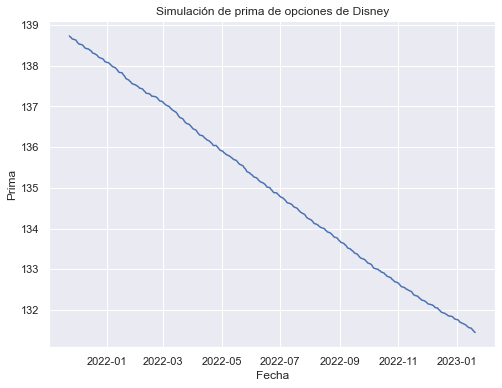

In [13]:
plt.figure(figsize = [8, 6])
plt.plot(put)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show()

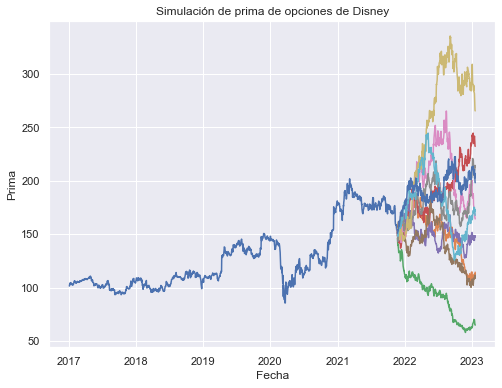

In [14]:
plt.figure(figsize = [8, 6]) # simulación de montecarlo
sim_normal = pd.concat([closes_dis, sim_closes[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])
plt.plot(sim_normal)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

In [15]:
put.iloc[-1] # valuación de la opción

Prima    131.452
Name: 2023-01-20 00:00:00, dtype: float64

In [16]:
confianza = 0.95 # intervalo de confianza
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc = mean_est, scale = sigma_est)
print("Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza", i2)

Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza (131.1317335020546, 131.77180847303515)


In [17]:
# Usando muestreo estratificado -> # estratros = nscen
U = (np.random.rand(ndays, nscen) + np.arange(0, nscen)) / nscen
Z = st.norm.ppf(U)
sim_ret2 = pd.DataFrame(sigma * Z + r, index = dates)
sim_closes2 = S0 * np.exp(sim_ret2.cumsum())
strike = pd.DataFrame(K * np.ones([ndays, nscen]), index = dates) # función de pago
put = pd.DataFrame({"Prima": np.exp(-r * ndays) * np.fmax(strike - sim_closes2, 0).T.mean()}, index = dates)

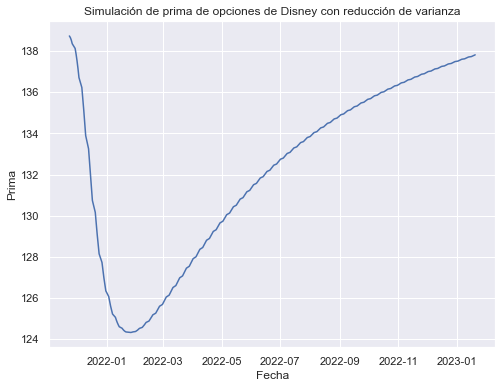

In [18]:
plt.figure(figsize = [8, 6])
plt.plot(put)
plt.title("Simulación de prima de opciones de Disney con reducción de varianza")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show()


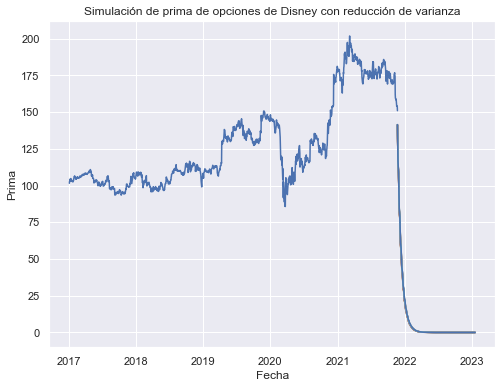

In [19]:
plt.figure(figsize = [8, 6]) # simulación de montecarlo
sim_reduc = pd.concat([closes_dis, sim_closes2[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]])
plt.plot(sim_reduc)
plt.title("Simulación de prima de opciones de Disney con reducción de varianza")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

In [20]:
put.iloc[-1] # valuación de la opción

Prima    137.817
Name: 2023-01-20 00:00:00, dtype: float64

In [21]:
sigma_est = sim_closes2.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc = mean_est)
print("Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza", i2)

Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza (135.85685486658488, 139.776782835665)


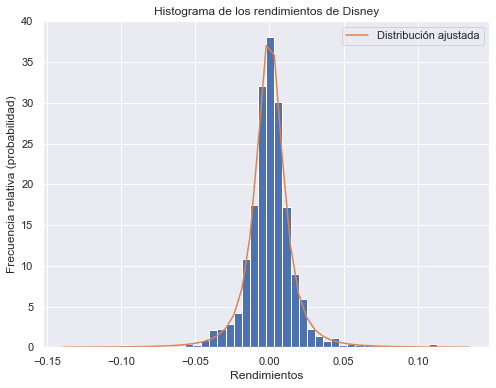

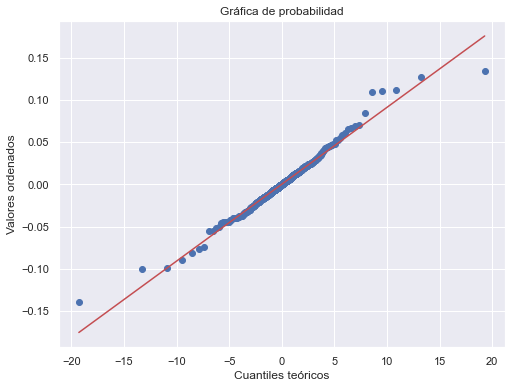

In [22]:
ren = daily_ret(closes_dis) # rendimientos
plt.figure(figsize = [8, 6])
y, x, _ = plt.hist(ren["DIS"], bins = 50, density = True) 
dist = "t" 
params = getattr(st, dist).fit(ren.values) 
curve_fit = getattr(st, dist).pdf(x, *params) 
plt.plot(x, curve_fit, label = "Distribución ajustada")
plt.title("Histograma de los rendimientos de Disney")
plt.xlabel("Rendimientos")
plt.ylabel("Frecuencia relativa (probabilidad)")
plt.legend()
plt.show()
plt.figure(figsize = [8, 6])
st.probplot(ren["DIS"], sparams = params[:-2], dist = dist, plot = plt); # gráfica Q-Q
plt.title("Gráfica de probabilidad")
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Valores ordenados")
plt.show()


In [23]:
K = 290
nscen = 100000
ndays = len(dates)
freq, values = np.histogram(rend + r - mu, bins = 2000) # histograma tomando la tasa libre de riesgo
prob = freq / np.sum(freq)
ret = np.random.choice(values[1:], ndays * nscen, p = prob) # simulación de los rendimientos
sim_ret_hist = pd.DataFrame(ret.reshape((ndays, nscen)), index = dates) # simulación de precios
sim_closes_hist = (closes_dis.iloc[-1, 0]) * np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K * np.ones(ndays * nscen).reshape((ndays, nscen)), index = dates)
put_hist = pd.DataFrame({"Prima": np.exp(-r * ndays) * np.fmax(strike - sim_closes_hist, 0).T.mean()}, index = dates)

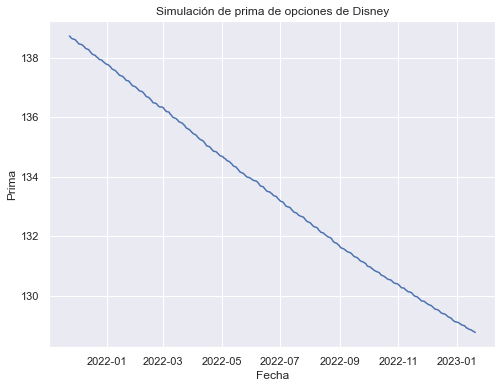

In [24]:
plt.figure(figsize = [8, 6])
plt.plot(put_hist)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

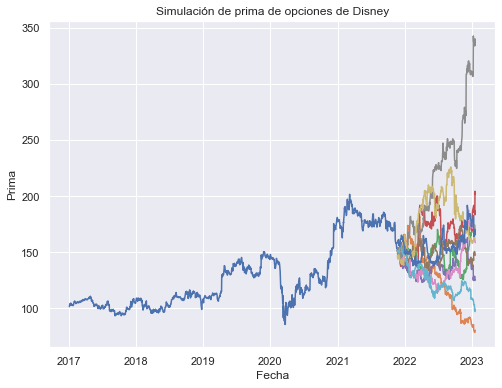

In [25]:
plt.figure(figsize = [8, 6]) # simulación de montecarlo
sim_hist = pd.concat([closes_dis, sim_closes_hist[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])
plt.plot(sim_hist)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

In [26]:
put_hist.iloc[-1] # valuación de la opción

Prima    128.76
Name: 2023-01-20 00:00:00, dtype: float64

In [27]:
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc = mean_est, scale = sigma_est)
print("Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza", i2)

Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza (128.43046986131034, 129.09007110696123)


#### Comparación metodo Black-Scholes

El valor actual de la opción es:
$$ \text{Valor actual de la opción put} = V(S_0, T) = K e^{-r \cdot T} \cdot N(-d_2) - S_0 \cdot N(-d_1) $$

Para calcular $d_1$ y $d_2$:
$$ d_1 = \frac{\ln{\frac{S_0}{K}} + (r + \frac{\sigma^2}{2}) \cdot T}{\sigma \sqrt{T}} = \frac{\ln{\frac{151.61}{290}} + (\frac{0.0018}{360} + \frac{0.01821^2}{2}) \cdot 423}{0.01821 \sqrt{423}} = -1.5388$$
$$ d_2 = \frac{\ln{\frac{S_0}{K}} + (r - \frac{\sigma^2}{2}) \cdot T}{\sigma \sqrt{T}} = \frac{\ln{\frac{151.61}{290}} + (\frac{0.0018}{360} - \frac{0.01821^2}{2}) \cdot 423}{0.01821 \sqrt{423}} = -1.9133$$

Entonces,
$$N(-d_1) = N(1.5388)= 0.9370$$ y $$N(-d_2) = N(1.9133) = 0.9719$$

Así, sustituyendo en la ecuación presentada anteriormente,
$$ \text{Valor actual de la opción} = V(151.61, 423) = 290 e^{-\frac{0.0018}{360} \cdot 423} \cdot 0.9719 - 151.61 \cdot 0.9370 = 139.1969 $$


Podemos observar que el valor en el metodo de Black-Scholes es mayor que las simulaciones anteriores 

### CODIGO ANTONIO

In [28]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [29]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

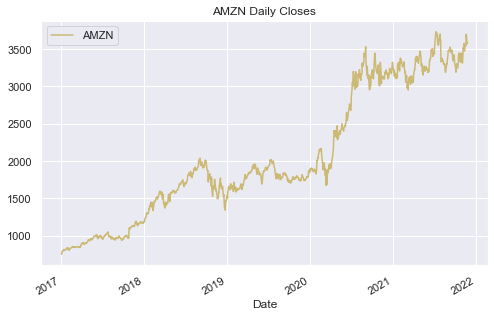

In [30]:
ticker = ['AMZN']
start_date = '2017-01-01'
amazon_closes = get_adj_closes(ticker, start_date)
amazon_closes.plot(c='y', figsize=(8,5));
plt.legend(ticker);
plt.title('AMZN Daily Closes');

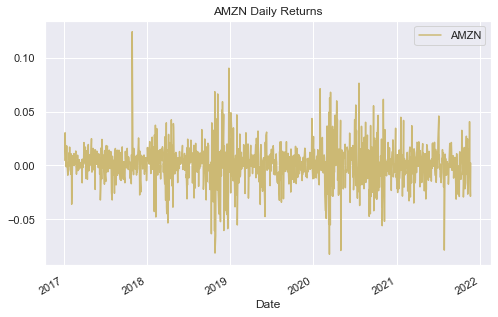

In [31]:
# Calculamos los rendimientos logaritmicos.
ret_amazon = calc_daily_ret(amazon_closes)

# Graficamos los rendimientos.
ret_amazon.plot(c='y', figsize=(8,5));
plt.legend(ticker);
plt.title('AMZN Daily Returns');

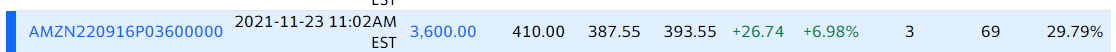

In [32]:
closes = get_adj_closes(['AMZN'], '2017-01-01')
closes_amazon = closes.loc[:,'AMZN']
closes_amazon

Date
2017-01-03     753.67
2017-01-04     757.18
2017-01-05     780.45
2017-01-06     795.99
2017-01-09     796.92
               ...   
2021-11-17    3549.00
2021-11-18    3696.06
2021-11-19    3676.57
2021-11-22    3572.57
2021-11-23    3580.04
Name: AMZN, Length: 1233, dtype: float64

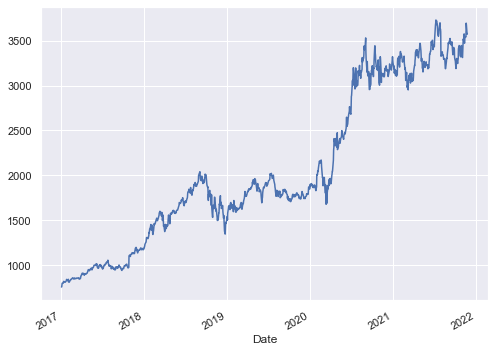

In [33]:
closes_amazon.plot(figsize=(8,6));

In [34]:
closes_amazon[-1]

3580.0400390625

In [35]:
ret_amazon = calc_daily_ret(closes_amazon)
ret_amazon

Date
2017-01-04    0.005
2017-01-05    0.030
2017-01-06    0.020
2017-01-09    0.001
2017-01-10   -0.001
              ...  
2021-11-17    0.002
2021-11-18    0.041
2021-11-19   -0.005
2021-11-22   -0.029
2021-11-23    0.002
Name: AMZN, Length: 1232, dtype: float64

In [36]:
mu = ret_amazon.mean()
sigma = ret_amazon.std()
r = 0.0021/360
mu, sigma, r

(0.0012647521750661832, 0.01857104388954334, 5.833333333333333e-06)

In [37]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = "2022-09-16"

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 3600
S0 = closes_amazon.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

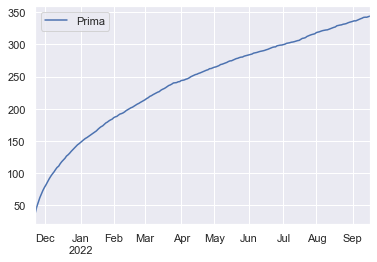

In [38]:
strike = K
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();

In [39]:
put.iloc[-1]

Prima    343.698
Name: 2022-09-16 00:00:00, dtype: float64

In [40]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(323.23159680504364, 364.1643764583547)


In [41]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_amazon-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [42]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
#expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

#K = opt_valuar.Strike
S0 = closes_amazon.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

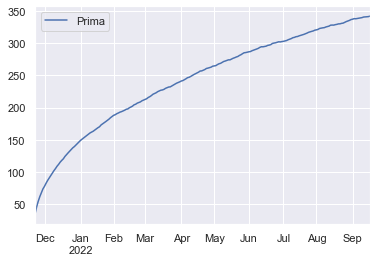

In [43]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [44]:
put_hist.iloc[-1]

Prima    342.272
Name: 2022-09-16 00:00:00, dtype: float64

In [45]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(321.730322664284, 362.8144662723955)


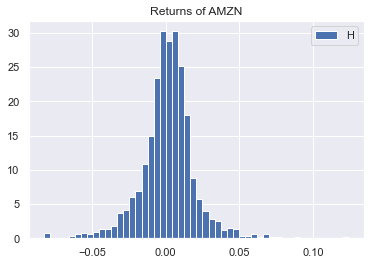

In [46]:
y, x, _ = plt.hist(ret_amazon, bins=50, density=True)
plt.legend('Histogram')
plt.title('Returns of AMZN')
plt.show();

In [47]:
prob = y/np.sum(y)
domain_values = x[1:]
S_0 = amazon_closes.iloc[-1,0]

ret_histo = np.random.choice(domain_values, ndays*nscen, p=prob)

# Rendimientos en un Data Frame.
sim_ret_hist = pd.DataFrame(ret_histo.reshape((ndays,nscen)),index=dates)

# Ya con los rendimientos definidos calculamos los precios.
S_T3 = S_0*np.exp(sim_ret_hist.cumsum())
S_T3.iloc[0,:] = S_0
S_T3

,0,1,2,...,9997,9998,9999
2021-11-23,3580.040,3580.040,3580.040,...,3580.040,3580.040,3580.040
2021-11-24,3580.980,3625.660,3595.812,...,3610.705,3580.980,3670.898
2021-11-25,3611.179,3551.965,3626.136,...,3626.136,3596.284,3701.855
2021-11-26,3656.716,3552.431,3656.716,...,3626.612,3567.145,3523.186
2021-11-29,3582.390,3582.390,3702.827,...,3612.127,3582.390,3523.648
...,...,...,...,...,...,...,...
2022-09-12,6812.742,7873.169,7712.128,...,6068.200,6018.243,7012.736
2022-09-13,6898.651,8138.927,7809.378,...,6068.996,6119.374,7130.579
2022-09-14,6956.829,8309.971,7746.103,...,6069.793,6120.177,7102.098
2022-09-15,6957.742,8242.641,7715.164,...,5971.048,6120.980,7015.497


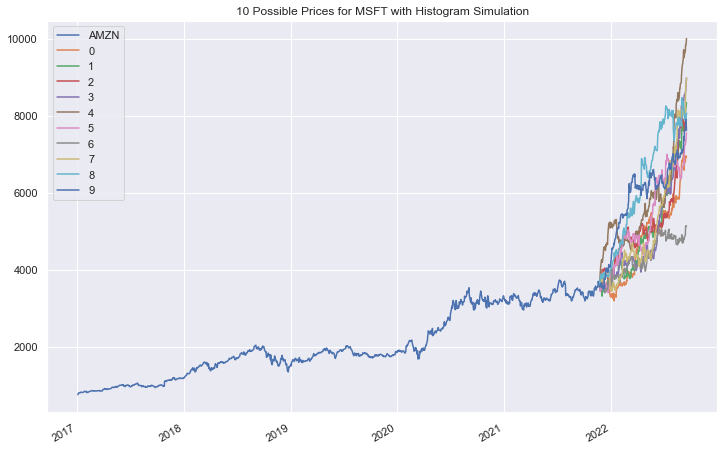

In [48]:
pd.concat([amazon_closes,S_T3.iloc[:,0:10]]).plot(figsize=(12,8));
plt.title('10 Possible Prices for MSFT with Histogram Simulation');

In [49]:
freq, values = np.histogram(ret_amazon+r-mu, bins=2000)
prob = freq/np.sum(freq)

# Simulación de los rendimientos.
ret_histo_rf = np.random.choice(values[1:], ndays*nscen, p=prob)

# Simulación de precios.
sim_ret_hist_rf = pd.DataFrame(ret_histo_rf.reshape((ndays,nscen)),index=dates)
S_T3_rf = S_0 * np.exp(sim_ret_hist_rf.cumsum())
S_T3_rf.iloc[0, :] = S_0
S_T3_rf

,0,1,2,...,9997,9998,9999
2021-11-23,3580.040,3580.040,3580.040,...,3580.040,3580.040,3580.040
2021-11-24,3656.374,3493.132,3644.680,...,3669.621,3600.137,3613.181
2021-11-25,3656.784,3510.169,3634.182,...,3756.749,3621.063,3659.808
2021-11-26,3692.891,3574.624,3638.348,...,3713.171,3635.342,3647.759
2021-11-29,3724.733,3580.201,3570.964,...,3744.028,3667.824,3683.777
...,...,...,...,...,...,...,...
2022-09-12,5755.224,3656.392,3022.037,...,2816.397,3610.960,3581.233
2022-09-13,5904.059,3658.315,2948.953,...,2829.549,3699.752,3577.196
2022-09-14,5649.268,3757.190,2824.024,...,2836.600,3686.810,3557.323
2022-09-15,5540.058,3786.064,2969.494,...,2746.348,3484.591,3576.521


Prima: 317.55148197823064 USD


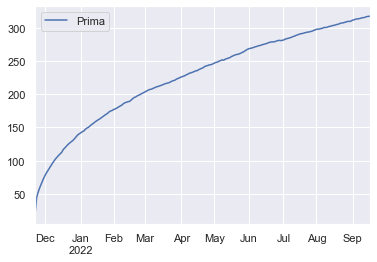

In [50]:
put_3 = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(K-S_T3_rf,np.zeros([ndays,nscen])).T.mean()}, index=dates)
put_3.plot();
print(f'Prima: {put_3.iloc[-1][0]} USD')

In [51]:
d1 = (np.log(S_0 / K) + (r + sigma**2/2) * ndays) / (sigma * np.sqrt(ndays))
d2 = (np.log(S_0 / K) + (r - sigma**2/2) * ndays) / (sigma * np.sqrt(ndays))

# Definimos el precio de la put, donde N(-d2) y N(-d1) se definen con la distribución de probabilidad acumulada normal.
put_teorico = K * np.exp(-r*ndays) * st.norm.cdf(-d2) - (S_0 * st.norm.cdf(-d1))
print(f'Prima B&S: {put_teorico} USD')

Prima B&S: 395.4370995726997 USD


El metodo de B&S nos da un resultado mas cercano al precio sacado en Yahoo Finance que los demas metodos, por lo que nos servirian solo para referencia, pero usando el B&S para mas certeza.